<a href="https://colab.research.google.com/github/NainaniJatinZ/Hack_Inversion-SIH/blob/main/Notebooks/Forecasting/SVM_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [48]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from matplotlib.pyplot import figure
import pandas as pd
# import yfinance
# from mpl_finance import candlestick_ohlc
import time
from datetime import datetime
import math
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data 

In [54]:
fret = pd.read_csv('/content/drive/MyDrive/SIH- Hack Inversion/Coding/data/nymex_4ind.csv')
fret.head()

,Unnamed: 0,Date,Close,Volume,Open,High,Low,SMA,EMA,MACD,DateTime,Custom
0,0,2012-03-12,2.269,82299.0,2.272,2.289,2.235,0.0,0.0,0.0,2012-03-12,100.0
1,1,2012-03-13,2.299,114622.0,2.270,2.338,2.207,0.0,0.0,0.0,2012-03-13,100.0
2,2,2012-03-14,2.284,120435.0,2.329,2.343,2.248,0.0,0.0,0.0,2012-03-14,100.0
3,3,2012-03-15,2.279,117788.0,2.275,2.331,2.234,0.0,0.0,0.0,2012-03-15,100.0
4,4,2012-03-16,2.326,112037.0,2.267,2.349,2.247,0.0,0.0,0.0,2012-03-16,100.0


In [55]:
fret = fret.drop(columns = ['Unnamed: 0'])
fret = fret.fillna(fret.mean())
fret.isna().sum()
# fret = fret.set_index('Date')

# train_df,test_df = fret[501:], fret[:500] 
# train_df=train_df.reindex(index=train_df.index[::-1])[181:]
# test_df = test_df.reindex(index=test_df.index[::-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


Date        0
Close       0
Volume      0
Open        0
High        0
Low         0
SMA         0
EMA         0
MACD        0
DateTime    0
Custom      0
dtype: int64

In [56]:
omitted = fret[181:]

In [58]:
omitted.head()

,Date,Close,Volume,Open,High,Low,SMA,EMA,MACD,DateTime,Custom
181,2012-11-20,3.832,80570.000000,3.730,3.841,3.725,2.941027,2.973668,0.467012,2012-11-20,88.726702
182,2012-11-21,3.903,123661.000000,3.835,3.910,3.786,2.952034,2.986227,0.470099,2012-11-21,90.110506
183,2012-11-22,3.903,121511.051917,3.903,3.903,3.903,2.962456,2.998615,0.472959,2012-11-22,90.072518
184,2012-11-23,3.901,49151.000000,3.912,3.933,3.830,2.973667,3.010810,0.475574,2012-11-23,90.028429
185,2012-11-26,3.730,77693.000000,3.864,3.868,3.704,2.983122,3.020529,0.475823,2012-11-26,72.773162


In [59]:
omitted = omitted.drop(columns = ['Date'])
omitted = omitted.drop(columns = ['Open'])
omitted = omitted.drop(columns = ['Low'])
omitted = omitted.drop(columns = ['High'])
omitted = omitted.drop(columns = ['DateTime'])


In [60]:
len(omitted)

2373

In [61]:
train_df, test_df = omitted[:1661], omitted[1661:]

In [62]:
train_df

,Close,Volume,SMA,EMA,MACD,Custom
181,3.832,80570.000000,2.941027,2.973668,0.467012,88.726702
182,3.903,123661.000000,2.952034,2.986227,0.470099,90.110506
183,3.903,121511.051917,2.962456,2.998615,0.472959,90.072518
184,3.901,49151.000000,2.973667,3.010810,0.475574,90.028429
185,3.730,77693.000000,2.983122,3.020529,0.475823,72.773162
...,...,...,...,...,...,...
1837,2.595,113570.000000,3.175952,2.930244,-0.155249,-45.013110
1838,2.619,122509.000000,3.171551,2.926038,-0.155903,-42.291581
1839,2.621,107626.000000,3.167041,2.921916,-0.156469,-41.729149
1840,2.659,87749.000000,3.163211,2.918363,-0.156497,-37.666586


In [63]:
train = train_df
scaler = MinMaxScaler(feature_range=(-4,4))
s_s = scaler.fit_transform(train['Volume'].values.reshape(-1,1))
s_s=np.reshape(s_s,len(s_s))
train['Volume']=s_s
test = test_df
s_s = scaler.transform(test['Volume'].values.reshape(-1,1))
s_s=np.reshape(s_s,len(s_s))
test['Volume']=s_s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [64]:
train = train.reset_index()
test = test.reset_index()

In [65]:
train

,index,Close,Volume,SMA,EMA,MACD,Custom
0,181,3.832,-2.519402,2.941027,2.973668,0.467012,88.726702
1,182,3.903,-1.727499,2.952034,2.986227,0.470099,90.110506
2,183,3.903,-1.767010,2.962456,2.998615,0.472959,90.072518
3,184,3.901,-3.096803,2.973667,3.010810,0.475574,90.028429
4,185,3.730,-2.572274,2.983122,3.020529,0.475823,72.773162
...,...,...,...,...,...,...,...
1656,1837,2.595,-1.912946,3.175952,2.930244,-0.155249,-45.013110
1657,1838,2.619,-1.748670,3.171551,2.926038,-0.155903,-42.291581
1658,1839,2.621,-2.022182,3.167041,2.921916,-0.156469,-41.729149
1659,1840,2.659,-2.387470,3.163211,2.918363,-0.156497,-37.666586


In [49]:
train_df = pd.read_csv('/content/drive/MyDrive/SIH- Hack Inversion/Coding/data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/SIH- Hack Inversion/Coding/data/test.csv')

In [50]:
train_df.head()

,Unnamed: 0,Close,Volume,Low,SMA,EMA,MACD,Custom
0,0,2.886,-3.839439,2.831,2.779286,2.931112,-0.192559,3.236326
1,1,2.768,-1.460156,2.762,2.778129,2.928908,-0.191076,-8.990846
2,2,2.716,-2.041879,2.706,2.777075,2.926031,-0.190250,-14.260936
3,3,2.748,-1.983361,2.707,2.775857,2.923625,-0.189000,-10.710547
4,4,2.812,-1.680450,2.752,2.774946,2.922116,-0.186938,-3.847346


In [51]:
train_df = train_df.drop(columns = ['Unnamed: 0'])
train_df = train_df.drop(columns = ['Low'])
test_df = test_df.drop(columns = ['Unnamed: 0'])
test_df = test_df.drop(columns = ['Low'])

In [53]:
train_df.shape

(1672, 6)

# Split Into Sequences for training

In [42]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [78]:
def split_series_single(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end], series[past_end:future_end]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [43]:
train.head()

,Close,Volume,SMA,EMA,MACD,Custom
0,3.832,-2.519402,2.941027,2.973668,0.467012,88.726702
1,3.903,-1.727499,2.952034,2.986227,0.470099,90.110506
2,3.903,-1.767010,2.962456,2.998615,0.472959,90.072518
3,3.901,-3.096803,2.973667,3.010810,0.475574,90.028429
4,3.730,-2.572274,2.983122,3.020529,0.475823,72.773162


In [83]:
n_past = 10
n_future = 1
n_features = 6

In [45]:
X_train, y_train = split_series(train.values,n_past, n_future)
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
# y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
# y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [66]:
X_train.shape

(1647, 10, 6)

In [ ]:
X_train.shape

(1858, 10, 8)

In [68]:
def sma(data_series, window_size):
  windows = data_series.rolling(window_size)
  moving_averages = windows.mean()
  moving_averages_list = moving_averages.tolist()
  without_nans = moving_averages_list[window_size - 1:]
  return without_nans


In [74]:
doday = sma(train['Close'], 5)
doday_1 = sma(test['Close'], 5)

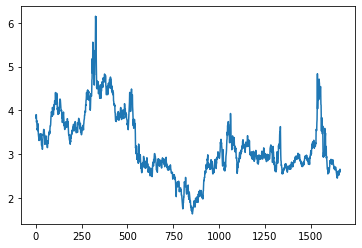

In [75]:
plt.plot(train['Close'])

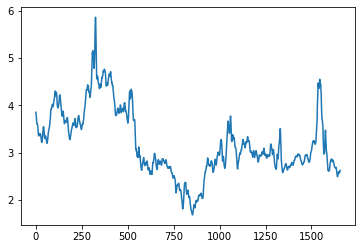

In [76]:
plt.plot(doday)

In [84]:
X_train, y_train = split_series_single(pd.Series(doday), n_past, n_future)
X_test, y_test = split_series_single(pd.Series(doday_1), n_past, n_future)

In [148]:
y_train.shape

(1647, 1)

In [90]:
X_train.shape

(1647, 10)

In [96]:
X_test.shape[0]

698

In [ ]:
y_test

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


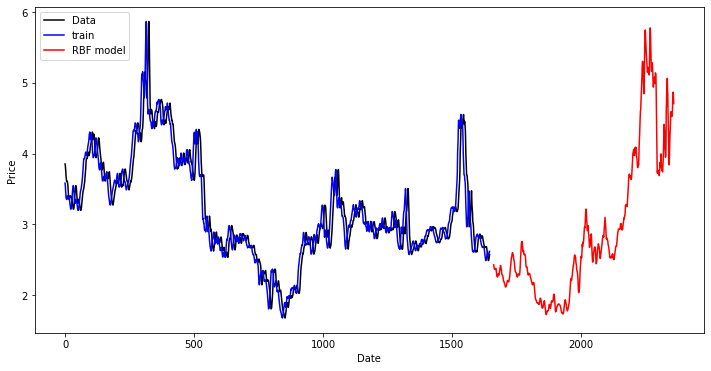

In [157]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(X_train, y_train)

plt.figure(figsize = (12,6))
plt.plot(X_train[:,0], color= 'black', label= 'Data')
plt.plot(y_train, color='blue', label = 'train')

plt.plot(np.linspace(1662, 1662+X_test.shape[0], X_test.shape[0]), svr_rbf.predict(X_test), color= 'red', label= 'RBF model') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [118]:
preds = list()
init = np.expand_dims(X_test[0], axis=0)
preds.append(init)
# for i in range()
pred = np.expand_dims(svr_rbf.predict(init), axis=0)
# preds.append(pred)
pred.shape

(1, 1)

In [117]:
preds = np.expand_dims(X_test[0], axis=0)
preds.shape

(1, 10)

(1647, 10)

In [164]:
import pickle

In [165]:
filename = '/content/drive/MyDrive/SIH- Hack Inversion/Coding/Models/svr.pkl'
pickle.dump(svr_rbf, open(filename, 'wb'))

In [159]:
preds = np.expand_dims(X_test[0], axis = 0)
pred = np.expand_dims(svr_rbf.predict(preds), axis = 0)
new_train = np.concatenate((X_train, preds), axis = 0)
new_train_y = np.concatenate((y_train, pred), axis = 0)
preds = np.concatenate((preds, pred), axis = 1)

for i in range(688):
  init = preds[:,-10:]
  pred = np.expand_dims(svr_rbf.predict(init), axis=0)
  preds = np.concatenate((preds, pred), axis = 1)

In [162]:
preds.shape

(1, 699)

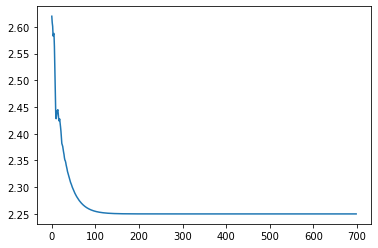

In [163]:
plt.plot(preds[0])

# Extra Code for testing

In [142]:
new_train_y.shape

(1656, 1)

In [149]:
new_train[-10:]

array([[2.6198, 2.6076, 2.601 , 2.5828, 2.5868, 2.5876, 2.5628, 2.5238,
        2.4906, 2.4396],
       [2.6076, 2.601 , 2.5828, 2.5868, 2.5876, 2.5628, 2.5238, 2.4906,
        2.4396, 2.395 ],
       [2.601 , 2.5828, 2.5868, 2.5876, 2.5628, 2.5238, 2.4906, 2.4396,
        2.395 , 2.3716],
       [2.5828, 2.5868, 2.5876, 2.5628, 2.5238, 2.4906, 2.4396, 2.395 ,
        2.3716, 2.3624],
       [2.5868, 2.5876, 2.5628, 2.5238, 2.4906, 2.4396, 2.395 , 2.3716,
        2.3624, 2.359 ],
       [2.5876, 2.5628, 2.5238, 2.4906, 2.4396, 2.395 , 2.3716, 2.3624,
        2.359 , 2.3606],
       [2.5628, 2.5238, 2.4906, 2.4396, 2.395 , 2.3716, 2.3624, 2.359 ,
        2.3606, 2.3608],
       [2.5238, 2.4906, 2.4396, 2.395 , 2.3716, 2.3624, 2.359 , 2.3606,
        2.3608, 2.3708],
       [2.4906, 2.4396, 2.395 , 2.3716, 2.3624, 2.359 , 2.3606, 2.3608,
        2.3708, 2.3766],
       [2.4396, 2.395 , 2.3716, 2.3624, 2.359 , 2.3606, 2.3608, 2.3708,
        2.3766, 2.3624]])

In [151]:
pred = np.expand_dims(svr_rbf.predict([new_train[-1]]), axis = 0)

In [152]:
pred

array([[2.3664315]])

In [153]:
pred = np.expand_dims(svr_rbf.predict([new_train[-1]]), axis = 0)
new_train_y = np.concatenate((new_train_y, pred), axis = 0)
# new_train_y.shape
svr_rbf.fit(new_train, new_train_y)
temp = np.expand_dims(new_train[-1, -9:], axis = 0 )

new_train = np.concatenate((new_train, new_train[-1, -9:]), axis = 0)


(1657, 1)

In [155]:
new_train[-1, -9:].shape

(9,)

In [145]:
pred.shape

(1, 10)

In [146]:
svr_rbf.predict(new_train[-10:])

array([2.42811578, 2.40249905, 2.38233852, 2.36538782, 2.36918009,
       2.37144466, 2.36357207, 2.36879472, 2.37884338, 2.3664315 ])

In [156]:
X_train.shape

(1647, 10)